### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import spacy
from spacy import displacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline, logging
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

In [3]:
df = pd.read_csv('top_movies.csv')

df.head()

,movie_name,genre,description
0,The Shawshank Redemption,"Drama, Crime",Imprisoned in the 1940s for the double murder ...
1,The Godfather,"Drama, Crime","Spanning the years 1945 to 1955, a chronicle o..."
2,The Godfather Part II,"Drama, Crime",In the continuing saga of the Corleone crime f...
3,Schindler's List,"Drama, History, War",The true story of how businessman Oskar Schind...
4,12 Angry Men,Drama,The defense and the prosecution have rested an...


### Genre Distribution Overview

The Top Movies dataset features a wide array of genres, with Drama, Comedy, Thriller, and Action appearing most frequently. This distribution highlights the dominance of dramatic and entertaining themes among top-rated films and provides important context for further analysis.

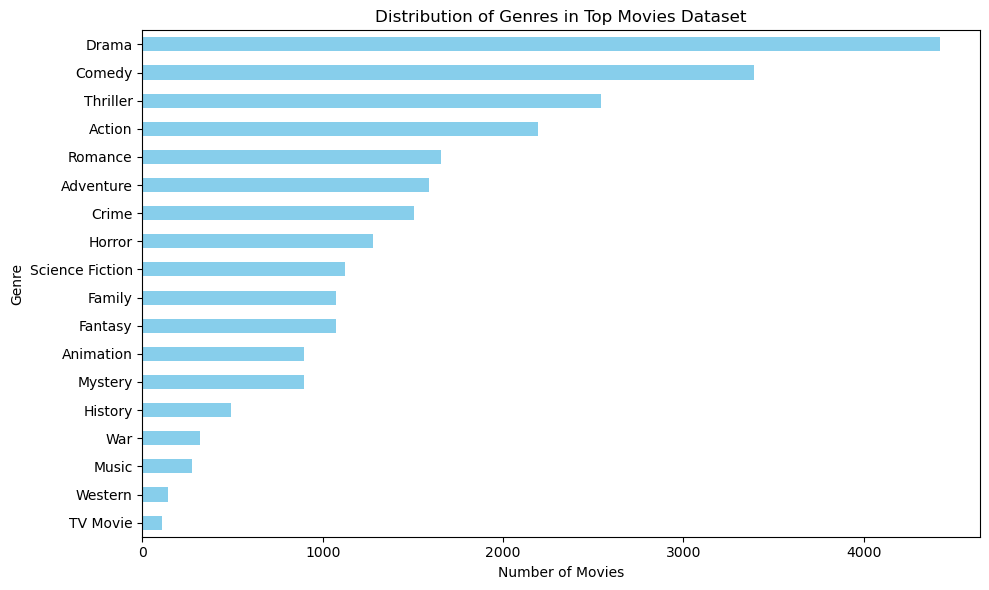

In [4]:
# Split genres and explode into one genre per row
df_exploded = df.assign(genre=df['genre'].str.split(',')).explode('genre')
df_exploded['genre'] = df_exploded['genre'].str.strip()

# Use value_counts to get distribution
genre_counts = df_exploded['genre'].value_counts()

# Plot the distribution
plt.figure(figsize=(10,6))
genre_counts.plot(kind='barh', color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.title('Distribution of Genres in Top Movies Dataset')
plt.tight_layout()
plt.show()


### Description Cleaning Overview

To prepare the movie summaries for analysis, a comprehensive text cleaning function was applied to each description. This process standardizes the text by converting it to lowercase, removing punctuation, and stripping extraneous whitespace. The result is a new clean_description column containing streamlined, noise-free plot summaries that are ideal for downstream NLP tasks.

In [5]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"[^a-z0-9 .,!?'\"-]", "", text)
    text = re.sub(r"[.!?]", ".", text)  
    text = re.sub(r"\.{2,}", ".", text) 
    text = re.sub(r"\[.*?\]", "", text) 
    text = re.sub(r"[^\w\s]", "", text)  

    return text.strip()

df['clean_description'] = df['description'].apply(clean_text)

df.head()


,movie_name,genre,description,clean_description
0,The Shawshank Redemption,"Drama, Crime",Imprisoned in the 1940s for the double murder ...,imprisoned in the 1940s for the double murder ...
1,The Godfather,"Drama, Crime","Spanning the years 1945 to 1955, a chronicle o...",spanning the years 1945 to 1955 a chronicle of...
2,The Godfather Part II,"Drama, Crime",In the continuing saga of the Corleone crime f...,in the continuing saga of the corleone crime f...
3,Schindler's List,"Drama, History, War",The true story of how businessman Oskar Schind...,the true story of how businessman oskar schind...
4,12 Angry Men,Drama,The defense and the prosecution have rested an...,the defense and the prosecution have rested an...


### Named Entity Extraction Overview

Named entity recognition (NER) was applied to the cleaned movie descriptions using spaCy, automatically identifying key entities such as dates, people, and locations within each plot. These entities, stored in a new column, support deeper analysis of characters, historical settings, and story context throughout the dataset.

In [6]:
nlp = spacy.load('en_core_web_sm')  

def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

# Apply entity extraction to the clean_description column
df['entities'] = df['clean_description'].apply(extract_entities)

df.head()

,movie_name,genre,description,clean_description,entities
0,The Shawshank Redemption,"Drama, Crime",Imprisoned in the 1940s for the double murder ...,imprisoned in the 1940s for the double murder ...,"[(the 1940s, DATE), (andy dufresne, PERSON)]"
1,The Godfather,"Drama, Crime","Spanning the years 1945 to 1955, a chronicle o...",spanning the years 1945 to 1955 a chronicle of...,"[(the years 1945 to 1955, DATE), (michael step..."
2,The Godfather Part II,"Drama, Crime",In the continuing saga of the Corleone crime f...,in the continuing saga of the corleone crime f...,"[(1910s, DATE), (new york, GPE), (the 1950s, D..."
3,Schindler's List,"Drama, History, War",The true story of how businessman Oskar Schind...,the true story of how businessman oskar schind...,"[(oskar schindler, PERSON), (over a thousand, ..."
4,12 Angry Men,Drama,The defense and the prosecution have rested an...,the defense and the prosecution have rested an...,[]


In [7]:
print(df['description'][0])

Imprisoned in the 1940s for the double murder of his wife and her lover, upstanding banker Andy Dufresne begins a new life at the Shawshank prison, where he puts his accounting skills to work for an amoral warden. During his long stretch in prison, Dufresne comes to be admired by the other inmates -- including an older prisoner named Red -- for his integrity and unquenchable sense of hope.


In [8]:
print(df['clean_description'][0])

imprisoned in the 1940s for the double murder of his wife and her lover upstanding banker andy dufresne begins a new life at the shawshank prison where he puts his accounting skills to work for an amoral warden during his long stretch in prison dufresne comes to be admired by the other inmates  including an older prisoner named red  for his integrity and unquenchable sense of hope


In [9]:
df.iloc[0]['entities'][0]

('the 1940s', 'DATE')

### Entity Visualization Example

To demonstrate the results of named entity recognition, a sample movie description is visualized using spaCy’s displacy. Entities such as dates and person names are clearly highlighted within the plot summary, offering an intuitive view of how the model extracts structured information from text.

In [10]:
# Pick a description to visualize 
example = df['clean_description'].iloc[0]
doc = nlp(example)

# Visualize in Jupyter Notebook
displacy.render(doc, style='ent', jupyter=True)

### Lemmatization Overview

To further standardize the text for NLP tasks, each cleaned description was lemmatized using spaCy. This process reduces words to their base forms and removes stopwords and punctuation, resulting in a concise clean_lemmas column that is well-suited for vectorization and topic modeling.

In [11]:
def lemmatized_string(text):
    doc = nlp(text)
    # Only keep words that are not stop words or punctuation
    lemmas = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    # Join them back with a space (NOT empty string, otherwise words stick together)
    return ' '.join(lemmas)

# Apply to your dataframe
df['clean_lemmas'] = df['clean_description'].apply(lemmatized_string)

print(df[['movie_name', 'clean_lemmas']].head())

                 movie_name                                       clean_lemmas
0  The Shawshank Redemption  imprison 1940 double murder wife lover upstand...
1             The Godfather  span year 1945 1955 chronicle fictional italia...
2     The Godfather Part II  continue saga corleone crime family young vito...
3          Schindler's List  true story businessman oskar schindler save th...
4              12 Angry Men  defense prosecution rest jury file jury room d...


### Document-Term Matrix Overview

A document-term matrix was generated from the lemmatized movie descriptions using a CountVectorizer. This matrix captures the frequency of each word across all records, creating a structured, numerical representation of the text that is ready for further NLP analysis such as topic modeling.

In [12]:
cv = CountVectorizer(stop_words='english', min_df=0.01, max_df=0.9)
dtm = cv.fit_transform(df['clean_lemmas'])
dtm_df = pd.DataFrame(dtm.toarray(), columns=cv.get_feature_names_out())
dtm_df

,accident,accidentally,act,action,adventure,affair,age,agent,alien,america,...,wife,win,witness,woman,work,world,wrong,year,york,young
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9415,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9416,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9417,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9418,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


### Top Terms Overview

The most frequently occurring words in the movie descriptions were identified, with terms like “life,” “young,” “family,” and “friend” appearing most often. These high-frequency words highlight the central themes and relationships that are common across the top movies in the dataset.

In [13]:
top_terms = dtm_df.sum().sort_values(ascending = False).head(10)
top_terms

life      1827
young     1351
new       1293
man       1099
world     1084
family    1061
friend     971
love       847
year       817
woman      757
dtype: int64

This horizontal bar chart displays the ten most frequent words found in the movie descriptions. Terms like “life,” “young,” “new,” and “family” dominate, emphasizing the central themes and recurring motifs present throughout the top movies in the dataset.

<Axes: >

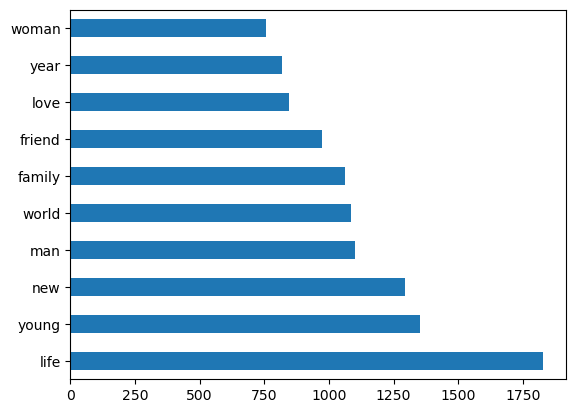

In [14]:
top_terms.plot(kind='barh')

### Sentiment Analysis Overview

Sentiment analysis was performed on the movie descriptions using VADER. For each description, the analyzer returns scores for negative, neutral, and positive sentiment, as well as an overall compound score. This provides a quick quantitative measure of the emotional tone present in each description.

In [15]:
# sentiment analysis
# create an analyzer object
analyzer = SentimentIntensityAnalyzer()

In [16]:
analyzer.polarity_scores(df['description'][0])

{'neg': 0.222, 'neu': 0.641, 'pos': 0.137, 'compound': -0.8316}

In [17]:
df['description'][0]

'Imprisoned in the 1940s for the double murder of his wife and her lover, upstanding banker Andy Dufresne begins a new life at the Shawshank prison, where he puts his accounting skills to work for an amoral warden. During his long stretch in prison, Dufresne comes to be admired by the other inmates -- including an older prisoner named Red -- for his integrity and unquenchable sense of hope.'

### VADER Sentiment Scores Column

A new column, vader_sentiment, was added to store the compound sentiment score for each movie description. Calculated using VADER, this score provides a concise numerical summary of the overall emotional tone expressed in each description.

In [18]:
def get_sentiment(text):
    return analyzer.polarity_scores(text)['compound']

In [19]:
df['vader_sentiment'] = df['description'].apply(get_sentiment)
df.head(2)

,movie_name,genre,description,clean_description,entities,clean_lemmas,vader_sentiment
0,The Shawshank Redemption,"Drama, Crime",Imprisoned in the 1940s for the double murder ...,imprisoned in the 1940s for the double murder ...,"[(the 1940s, DATE), (andy dufresne, PERSON)]",imprison 1940 double murder wife lover upstand...,-0.8316
1,The Godfather,"Drama, Crime","Spanning the years 1945 to 1955, a chronicle o...",spanning the years 1945 to 1955 a chronicle of...,"[(the years 1945 to 1955, DATE), (michael step...",span year 1945 1955 chronicle fictional italia...,-0.9371


The table below lists the ten movies with the highest positive sentiment scores based on their descriptions, as determined by VADER. These films feature the most optimistic, uplifting, or cheerful language in the dataset, as reflected by their high compound sentiment values.

In [20]:
# top 10 most positive movies
df[['movie_name', 'description', 'vader_sentiment']].sort_values(by='vader_sentiment', ascending=False).head(10)

,movie_name,description,vader_sentiment
8876,The Smurfs 2,The evil wizard Gargamel creates a couple of m...,0.9898
4697,Barbie: A Perfect Christmas,"Join Barbie and her sisters Skipper, Stacie an...",0.9895
2284,Full Out,Based on the true life story of California gym...,0.9890
1487,The Big Blue,Two men answer the call of the ocean in this r...,0.9880
4736,"Mektoub, My Love: Canto Uno","Amin, an aspiring screenwriter living in Paris...",0.9868
4052,Pitch Perfect 2,"The Bellas are back, and they are better than ...",0.9863
4483,Only You,Two childhood paranormal incidents have convin...,0.9844
8189,When in Rome,Teenage sisters Charli and Lola are on the ver...,0.9844
6347,A Midsummer Night's Dream,"The lovely Hermia is to wed Demetrius, but she...",0.9842
2697,Loro 2,"""Loro"", in two parts, is a period movie that c...",0.9824


The table below highlights the ten movies with the lowest sentiment scores based on their descriptions, as measured by VADER. These films contain the most negative, dark, or somber language in the dataset, reflected by their strongly negative compound sentiment values.

In [21]:
# top 10 most negative movies
df[['movie_name', 'description', 'vader_sentiment']].sort_values(by='vader_sentiment', ascending=True).head(10)

,movie_name,description,vader_sentiment
1901,Watchmen,"In a gritty and alternate 1985, the glory days...",-0.9873
7812,Halloween Ends,Four years after the events of Halloween in 20...,-0.9862
4337,The Bone Collector,Lincoln Rhyme was the department's top homicid...,-0.9856
8508,Muse,"Samuel Salomon, a literature professor, has be...",-0.9855
1167,Lady Snowblood,Yuki's family is nearly wiped out before she i...,-0.9846
5800,Four Flies on Grey Velvet,"Roberto, a drummer in a rock band, keeps recei...",-0.9846
7663,So I Married an Axe Murderer,"Just after a bad breakup, Charlie MacKenzie fa...",-0.9843
5577,The Karate Kid,Twelve-year-old Dre Parker could have been the...,-0.9840
9300,Grave Encounters 2,Tortured by the ghosts of the demonized insane...,-0.9839
6988,Deliver Us from Evil,When a frightening wave of violence sweeps thr...,-0.9834


### DistilBERT Sentiment Analysis Overview

Movie descriptions were analyzed for sentiment using a fine-tuned DistilBERT model. For each description, the model predicts a sentiment label (POSITIVE or NEGATIVE) along with a confidence score, offering a more nuanced and context-aware sentiment classification compared to traditional rule-based methods. This enables robust detection of emotional tone across all movie summaries in the dataset.

In [22]:
logging.set_verbosity_error()

sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="distilbert/distilbert-base-uncased-finetuned-sst-2-english",
    device= 0 
)

distilbert_sentiment = df['description'].apply(sentiment_analyzer)
distilbert_sentiment

0       [{'label': 'POSITIVE', 'score': 0.998896241188...
1       [{'label': 'POSITIVE', 'score': 0.993454873561...
2       [{'label': 'POSITIVE', 'score': 0.993720769882...
3       [{'label': 'POSITIVE', 'score': 0.999289035797...
4       [{'label': 'NEGATIVE', 'score': 0.994850933551...
                              ...                        
9415    [{'label': 'POSITIVE', 'score': 0.989908814430...
9416    [{'label': 'NEGATIVE', 'score': 0.621867656707...
9417    [{'label': 'NEGATIVE', 'score': 0.998876631259...
9418    [{'label': 'NEGATIVE', 'score': 0.989599347114...
9419    [{'label': 'POSITIVE', 'score': 0.997423648834...
Name: description, Length: 9420, dtype: object

### Sentiment Comparison 

Both VADER and DistilBERT sentiment scores were calculated for each movie description. This table highlights the most negative movies by DistilBERT, allowing direct comparison with VADER scores. The results help illustrate how each model interprets emotional tone in film summaries.

In [23]:
df['label_distilbert'] = distilbert_sentiment.apply(lambda x: x[0]['label'])
df['score_distilbert'] = distilbert_sentiment.apply(lambda x: x[0]['score'])
df['distilbert_sentiment'] = df.apply(lambda row: row['score_distilbert'] if row['label_distilbert'] == 'POSITIVE' else -row['score_distilbert'], axis=1)

In [24]:
df[['movie_name', 'description', 'vader_sentiment', 'distilbert_sentiment']].sort_values('distilbert_sentiment').head()

,movie_name,description,vader_sentiment,distilbert_sentiment
9115,Psycho III,"When Maureen Coyle, a suicidal nun who resembl...",-0.4902,-0.999771
9088,High-Rise,Life for the residents of a tower block begins...,-0.4404,-0.999753
2891,The Disaster Artist,An aspiring actor in Hollywood meets an enigma...,-0.4404,-0.999747
4434,Final Cut,Things go badly for a small film crew shooting...,-0.7269,-0.999746
7671,Date Night,Phil and Claire Foster fear that their mild-ma...,-0.8807,-0.999736


### TF-IDF Matrix Overview

A TF-IDF (Term Frequency-Inverse Document Frequency) matrix was generated from the lemmatized movie descriptions. Each row represents a movie, and each column reflects the importance of a term within the dataset. This sparse matrix captures not just word presence, but how uniquely each term describes a movie compared to the entire collection, supporting advanced text analysis and feature extraction.

In [25]:
tv = TfidfVectorizer(stop_words='english', min_df=.01, max_df=.2)
tfidf = tv.fit_transform(df['clean_lemmas'])
tfidf_df = pd.DataFrame(tfidf.toarray(), columns=tv.get_feature_names_out())
tfidf_df

,accident,accidentally,act,action,adventure,affair,age,agent,alien,america,...,wife,win,witness,woman,work,world,wrong,year,york,young
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.229223,0.0,0.0,0.0,0.221415,0.000000,0.0,0.00000,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.21512,0.000000,0.183954
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.340647,0.226242
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.342207,0.283545,0.0,0.00000,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.249098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.000000
9416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.000000
9417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.298220,0.0,0.00000,0.000000,0.000000
9418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.700784,0.0,0.00000,0.000000,0.000000


The top terms by total TF-IDF weight highlight the most distinctive and significant words across all movie descriptions.

In [26]:
top_weights = tfidf_df.sum().sort_values(ascending =False).head(10)
top_weights

life      363.756912
young     295.653893
new       275.607360
man       256.882528
family    252.627123
world     244.105166
friend    226.070293
love      210.436402
woman     199.216707
year      195.191957
dtype: float64

### NMF Model Fitting

Non-negative Matrix Factorization (NMF) was applied to the TF-IDF matrix of movie descriptions, extracting seven underlying topics. The resulting matrices represent the association of each movie with each topic (document-topic matrix) and the importance of each word in each topic (topic-term matrix). This step sets the stage for discovering key thematic patterns in the dataset.

In [27]:
nmf_model = NMF(n_components=7, random_state=42, max_iter=500) 
W = nmf_model.fit_transform(tfidf_df)  # document-topic matrix
H = nmf_model.components_  # topic-term matrix

A helper function was used to display the top words for each topic extracted by NMF. This reveals the main themes in the dataset, making it easier to interpret what each topic represents, such as school and friendship, family, or themes of love and conflict. These keywords help label and understand the underlying structure of the movie descriptions.

In [28]:
# create a function to view the top terms in each topic
def display_topics(H, num_words=10):
    for topic_num, topic_array in enumerate(H):
        top_features = topic_array.argsort()[::-1][:num_words]
        top_words = [tv.get_feature_names_out()[i] for i in top_features]
        print("Topic", topic_num+1, ":", ', '.join(top_words))

display_topics(H)

Topic 1 : school, friend, high, good, girl, student, year, teacher, decide, day
Topic 2 : life, live, change, turn, day, meet, career, forever, decide, accident
Topic 3 : young, man, woman, meet, murder, discover, father, girl, mysterious, mother
Topic 4 : world, war, force, team, save, fight, battle, mission, group, lead
Topic 5 : family, home, father, son, child, mother, live, return, daughter, house
Topic 6 : new, york, city, help, work, cop, home, start, apartment, couple
Topic 7 : love, fall, story, true, relationship, film, tell, beautiful, woman, marry


### Document-Topic Weight Matrix

The document-topic matrix maps each movie description to the discovered topics, showing the strength of association (weight) with each theme. Each row represents a movie, and each column displays the weight indicating how strongly the movie is related to a particular topic, such as “school & teen life,” “mystery,” or “family & home.” This structured output enables analysis of thematic trends and topic prominence across the entire movie dataset.

In [29]:
# documents to topics
doc_topics = pd.DataFrame(W)
doc_topics.columns = ['school & teen life', 'life changes & career', 'mystery', 'war', 'family & home', 'urban life', 'love']
doc_topics

,school & teen life,life changes & career,mystery,war,family & home,urban life,love
0,0.001080,0.056760,0.021929,0.021960,0.015721,0.055458,0.001537
1,0.000000,0.048920,0.034402,0.005254,0.140667,0.000000,0.000000
2,0.000000,0.000000,0.032700,0.000000,0.150196,0.110808,0.000000
3,0.000000,0.066645,0.000000,0.108224,0.000000,0.000000,0.037119
4,0.004582,0.000000,0.095280,0.007801,0.025640,0.002113,0.000000
...,...,...,...,...,...,...,...
9415,0.000000,0.136842,0.000000,0.016488,0.000000,0.003198,0.000000
9416,0.000000,0.120274,0.000768,0.007714,0.122556,0.000000,0.007198
9417,0.059690,0.000000,0.000000,0.024624,0.076160,0.000000,0.043145
9418,0.000000,0.000000,0.000000,0.066541,0.197693,0.000000,0.000000


### Movies with Topic Weights

The movies_topics DataFrame merges each movie’s title and description with its topic weights, as derived from the topic modeling step. This table shows, for each movie, the strength of association with each discovered topic (such as “school & teen life,” “war,” or “family & home”), enabling quick exploration of thematic composition at the individual movie level.

In [30]:
pd.set_option('display.max_colwidth', None)

movies_topics = pd.concat([df[['movie_name', 'description']], doc_topics], axis=1)
movies_topics.head()

,movie_name,description,school & teen life,life changes & career,mystery,war,family & home,urban life,love
0,The Shawshank Redemption,"Imprisoned in the 1940s for the double murder of his wife and her lover, upstanding banker Andy Dufresne begins a new life at the Shawshank prison, where he puts his accounting skills to work for an amoral warden. During his long stretch in prison, Dufresne comes to be admired by the other inmates -- including an older prisoner named Red -- for his integrity and unquenchable sense of hope.",0.001080,0.056760,0.021929,0.021960,0.015721,0.055458,0.001537
1,The Godfather,"Spanning the years 1945 to 1955, a chronicle of the fictional Italian-American Corleone crime family. When organized crime family patriarch, Vito Corleone barely survives an attempt on his life, his youngest son, Michael steps in to take care of the would-be killers, launching a campaign of bloody revenge.",0.000000,0.048920,0.034402,0.005254,0.140667,0.000000,0.000000
2,The Godfather Part II,"In the continuing saga of the Corleone crime family, a young Vito Corleone grows up in Sicily and in 1910s New York. In the 1950s, Michael Corleone attempts to expand the family business into Las Vegas, Hollywood and Cuba.",0.000000,0.000000,0.032700,0.000000,0.150196,0.110808,0.000000
3,Schindler's List,The true story of how businessman Oskar Schindler saved over a thousand Jewish lives from the Nazis while they worked as slaves in his factory during World War II.,0.000000,0.066645,0.000000,0.108224,0.000000,0.000000,0.037119
4,12 Angry Men,"The defense and the prosecution have rested and the jury is filing into the jury room to decide if a young Spanish-American is guilty or innocent of murdering his father. What begins as an open and shut case soon becomes a mini-drama of each of the jurors' prejudices and preconceptions about the trial, the accused, and each other.",0.004582,0.000000,0.095280,0.007801,0.025640,0.002113,0.000000


The table below reveals the top movies that most prominently reflect high school experiences, friendships, and coming-of-age stories, as measured by their topic modeling weights. This approach enables quick identification of films that best represent a chosen theme in the dataset.

In [31]:
# sort on urban & friendship topic
movies_topics.sort_values('school & teen life', ascending=False).head()

,movie_name,description,school & teen life,life changes & career,mystery,war,family & home,urban life,love
6364,Sex Drive,A high school senior drives cross-country with his best friends to hook up with a babe he met online.,0.144561,0.00000,0.000000,0.0,0.000000,0.0,0.000000
7438,The Outcasts,"After falling victim to a humiliating prank by the high school Queen Bee, best friends and world-class geeks, Mindy and Jodi, decide to get their revenge by uniting the outcasts of the school against her and her circle of friends.",0.132376,0.00000,0.000000,0.0,0.000000,0.0,0.026609
7227,The Immature,"Six high school friends in their 40s who haven't seen each other in nearly 20 years rekindle their younger selves after a court cancels their diploma, forcing them to repeat the final high school exam.",0.131069,0.00000,0.023703,0.0,0.000000,0.0,0.000000
2653,The Edge of Seventeen,"Two high school girls are best friends until one dates the other's older brother, who is totally his sister's nemesis.",0.128161,0.00000,0.000000,0.0,0.002413,0.0,0.000000
9308,Dude,Four best friends negotiate loss and major life changes during the last two weeks of high school.,0.126153,0.09062,0.000000,0.0,0.000000,0.0,0.000000


### Dominant Topic Assignment

For each movie, the dominant topic is determined by selecting the theme with the highest topic modeling weight. This adds a new column to the dataset, indicating which topic most strongly characterizes each movie’s description. By associating every film with its most relevant topic, this view enables easy sorting, filtering, and analysis of the main narrative focus across the entire collection.

In [32]:
movies_topics['dominant_topic'] = doc_topics.idxmax(axis=1)
movies_topics.head()

,movie_name,description,school & teen life,life changes & career,mystery,war,family & home,urban life,love,dominant_topic
0,The Shawshank Redemption,"Imprisoned in the 1940s for the double murder of his wife and her lover, upstanding banker Andy Dufresne begins a new life at the Shawshank prison, where he puts his accounting skills to work for an amoral warden. During his long stretch in prison, Dufresne comes to be admired by the other inmates -- including an older prisoner named Red -- for his integrity and unquenchable sense of hope.",0.001080,0.056760,0.021929,0.021960,0.015721,0.055458,0.001537,life changes & career
1,The Godfather,"Spanning the years 1945 to 1955, a chronicle of the fictional Italian-American Corleone crime family. When organized crime family patriarch, Vito Corleone barely survives an attempt on his life, his youngest son, Michael steps in to take care of the would-be killers, launching a campaign of bloody revenge.",0.000000,0.048920,0.034402,0.005254,0.140667,0.000000,0.000000,family & home
2,The Godfather Part II,"In the continuing saga of the Corleone crime family, a young Vito Corleone grows up in Sicily and in 1910s New York. In the 1950s, Michael Corleone attempts to expand the family business into Las Vegas, Hollywood and Cuba.",0.000000,0.000000,0.032700,0.000000,0.150196,0.110808,0.000000,family & home
3,Schindler's List,The true story of how businessman Oskar Schindler saved over a thousand Jewish lives from the Nazis while they worked as slaves in his factory during World War II.,0.000000,0.066645,0.000000,0.108224,0.000000,0.000000,0.037119,war
4,12 Angry Men,"The defense and the prosecution have rested and the jury is filing into the jury room to decide if a young Spanish-American is guilty or innocent of murdering his father. What begins as an open and shut case soon becomes a mini-drama of each of the jurors' prejudices and preconceptions about the trial, the accused, and each other.",0.004582,0.000000,0.095280,0.007801,0.025640,0.002113,0.000000,mystery


In [33]:
topic_counts = movies_topics['dominant_topic'].value_counts()

This bar chart summarizes the distribution of movies according to their dominant topic, as identified by the topic modeling process.

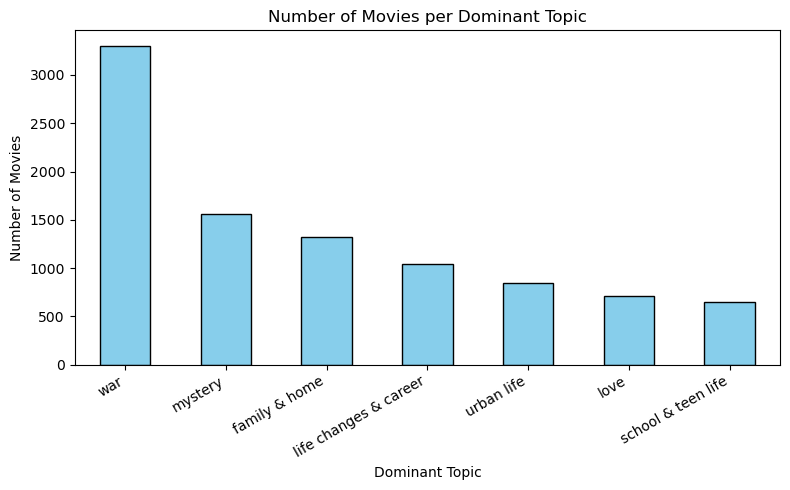

In [34]:
plt.figure(figsize=(8,5))
topic_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Movies per Dominant Topic')
plt.xlabel('Dominant Topic')
plt.ylabel('Number of Movies')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

### Movie Recommendations Based on Topic Similarity
The table shows the top 10 movies most similar to “The Godfather,” ranked by cosine similarity of their topic model vectors. This highlights films with the most closely related thematic content based on their document-topic distributions. However, recommended movies are not entirely similar. 
Let’s try a modern approach.

In [35]:
# Set the index of doc_topics to movie names for easier lookup and display
doc_topics.index = movies_topics['movie_name']

target_movie = "The Godfather"  # Change to any movie in the dataset

# Get the topic vector for the target movie
target_vector = doc_topics.loc[target_movie].values.reshape(1, -1)

# Compute cosine similarities between the target movie and all other movies
similarities = cosine_similarity(target_vector, doc_topics.values)[0]

results = pd.DataFrame({
    'movie': doc_topics.index,
    'similarity': similarities
})

# Sort by similarity (highest first) and exclude the movie itself
results = results[results['movie'] != target_movie]
results = results.sort_values(by='similarity', ascending=False)

top_n = 10
results.head(top_n)


,movie,similarity
3631,City Island,0.998229
5408,Star Trek III: The Search for Spock,0.997109
3026,The Light Between Oceans,0.988623
8893,High Life,0.987940
3234,The Birdcage,0.986901
1418,My Father and My Son,0.983262
2699,The Glass Castle,0.981949
5155,Hours,0.980426
520,War Room,0.979973
2353,South Park: Post COVID,0.977948


### Semantic Embeddings for Descriptions

To capture deeper semantic meaning, each movie description is transformed into a high-dimensional embedding using a pre-trained sentence transformer model. These embeddings encode the nuanced context and content of every summary, enabling robust similarity comparisons beyond simple keyword or topic overlap. This approach lays the foundation for more accurate, context-aware movie recommendations.

In [36]:
from sentence_transformers import SentenceTransformer
# Load a pre-trained sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Compute embeddings for all movie descriptions
desc_embeddings = model.encode(df['description'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/295 [00:00<?, ?it/s]

Movie description embeddings are normalized before calculating cosine similarities. This creates a matrix that measures how semantically close each pair of movies is, making it easier to identify truly similar films.

In [37]:
# Normalize embeddings (optional but helps for cosine similarity)
desc_embeddings_norm = normalize(desc_embeddings)

# Compute cosine similarity matrix
desc_similarity_matrix = cosine_similarity(desc_embeddings_norm)


This function recommends movies by comparing the semantic embeddings of their descriptions. For a given title, it finds the most similar movies based on cosine similarity, only returning those above a chosen threshold. This ensures that recommendations are more semantically relevant to the selected film.

In [38]:
def recommend_by_title_embedding(title, df, desc_similarity_matrix, top_n=5, threshold=0.5):
    idx = df[df['movie_name'] == title].index[0]
    sim_scores = desc_similarity_matrix[idx]
    # Exclude the movie itself
    sim_scores[idx] = -1
    # Filter by threshold
    filtered_indices = np.where(sim_scores >= threshold)[0]
    # Sort those by similarity
    top_indices = filtered_indices[np.argsort(sim_scores[filtered_indices])[::-1]][:top_n]
    return df.iloc[top_indices][['movie_name', 'description']]


The table below shows the top 5 movies most similar to “The Godfather,” ranked by cosine similarity of their description embeddings from a modern sentence transformer. This method recommends films with highly similar narrative content and context, based on the meaning of their plot descriptions.

In [39]:
recommend_by_title_embedding('The Godfather', df, desc_similarity_matrix, top_n=5, threshold=0.5)

,movie_name,description
2,The Godfather Part II,"In the continuing saga of the Corleone crime family, a young Vito Corleone grows up in Sicily and in 1910s New York. In the 1950s, Michael Corleone attempts to expand the family business into Las Vegas, Hollywood and Cuba."
1624,The Godfather Part III,"In the midst of trying to legitimize his business dealings in 1979 New York and Italy, aging mafia don, Michael Corleone seeks forgiveness for his sins while taking a young protege under his wing."
5121,My Name Is Vendetta,"After old enemies kill his family, a former mafia enforcer and his feisty daughter flee to Milan, where they hide out while plotting their revenge."
7311,The Devil's Own,"Frankie McGuire, one of the IRA's deadliest assassins, draws an American family into the crossfire of terrorism. But when he is sent to the U.S. to buy weapons, Frankie is housed with the family of Tom O'Meara, a New York cop who knows nothing about Frankie's real identity. Their surprising friendship, and Tom's growing suspicions, forces Frankie to choose between the promise of peace or a lifetime of murder."
1178,"Ugly, Dirty and Bad","Giacinto lives with his wife, their ten children and various other family members in a shack on the hills of Rome. Some time ago he has lost his left eye while at work, and got a consistent sum of money from the insurance company, which he keeps hidden from the rest of the family. His whole life is now based on defending the money he sees as his own, while the rest of the family tries to kill him."


### Comparison of Recommendation Methods

While topic modeling combined with cosine similarity can uncover general thematic similarities between movies, this approach has some limitations. Topic models reduce complex descriptions to broad topic weights, which may overlook subtle narrative or contextual details unique to each film. As a result, recommendations might miss movies that are semantically similar but do not share the same overall topic distribution. These limitations can be reduced by refining preprocessing, tuning the number of topics, including bigrams or trigrams for richer themes, and setting a minimum similarity threshold. Together, these adjustments can help produce more focused and relevant recommendations with the traditional approach.

More modern approaches, such as embedding-based similarity using models like Sentence Transformers, capture deeper contextual and semantic relationships between descriptions. This results in more accurate and relevant movie recommendations, as the semantic meaning and context of each movie are directly compared.